In [14]:
%load_ext memory_profiler

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
from dask.distributed import Client, LocalCluster, wait
from itertools import chain
from pathlib import Path
from glob import glob

In [9]:
from xorca.lib import load_xorca_dataset
from xorca.calc import calculate_speed, calculate_psi, calculate_moc

In [50]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit=32e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40905 instead
  expected, actual


In [51]:
client

Client Scheduler: tcp://127.0.0.1:39525 Dashboard: http://127.0.0.1:40905/status,Cluster Workers: 8 Cores: 16 Memory: 238.42 GiB


## Read mesh

In [13]:
aux_path = Path('/gxfs_work1/geomar/smomw352/')
aux_files = list(sorted(aux_path.glob("[m]*_orca12.nc")))
print(aux_files)

[PosixPath('/gxfs_work1/geomar/smomw352/mask_orca12.nc'), PosixPath('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc'), PosixPath('/gxfs_work1/geomar/smomw352/mesh_zgr_orca12.nc')]


## Read data

In [6]:
expnames = ['FOCI_BJK019']
times = [slice('1956-12-01','1956-12-31')]

In [47]:
t_5d_all = []
u_5d_all = []
v_5d_all = []
i_5d_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    
    time_str = '19561201_19561231'
    
    chunks = {'x':4322, 'y':3059, 'deptht': 1, 'depthu':1, 'depthv':1}
    
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/nemo/' % (exp,)
    tfiles = '%s/%s_5d_%s_grid_T.nc' % (ddir,exp,time_str)
    print(tfiles)
    t_5d = xr.open_mfdataset(tfiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)
    
    ufiles = '%s/%s_5d_%s_grid_U.nc' % (ddir,exp,time_str)
    u_5d = xr.open_mfdataset(ufiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)
    
    vfiles = '%s/%s_5d_%s_grid_V.nc' % (ddir,exp,time_str)
    v_5d = xr.open_mfdataset(vfiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)
    
    ifiles = '%s/%s_5d_%s_icemod.nc' % (ddir,exp,time_str)
    i_5d = xr.open_mfdataset(ifiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)

    t_5d_all.append(t_5d)
    u_5d_all.append(u_5d)
    v_5d_all.append(v_5d)
    i_5d_all.append(i_5d)

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_19561201_19561231_grid_T.nc


In [48]:
t_5d

<xarray.Dataset>
Dimensions:               (y: 3059, x: 4322, deptht: 75, axis_nbounds: 2, time: 6)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1956-12-03T12:00:00 ... 1956-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/18)
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
    toce                  (time, deptht, y, x) float32 dask.array<chunksize=(6, 1, 3059, 4322), meta=np.ndarray>
    soce                  (time, deptht, y, x) float32 dask.array<chunksize=(6, 1, 3059, 4322), meta=np.ndarray>
    mldr10_1              (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    ...                    ...
    qsr                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    qt                    (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    qns_cal               (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    sst                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    sss                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    ssh                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
Attributes:
    name:         FOCI_BJK019_5d_19561201_19561231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Nov-10 03:37:28 GMT
    uuid:         ab8cf80a-f66f-4440-a08a-8315ac95f3b5
    history:      Thu Nov 10 14:23:02 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

## Calculate speed

In [59]:
speeds = []
for ji, (ds_u, ds_v) in enumerate( zip(u_5d_all, v_5d_all) ):
    
    _da = ((ds_u['uoce'].rename({'depthu':'deptht'}).isel(time=0)**2 + 
            ds_v['voce'].rename({'depthv':'deptht'}).isel(time=0)**2)**0.5).compute()
    
    speeds.append(_da)

In [60]:
speeds[0]

<xarray.DataArray (deptht: 75, y: 3059, x: 4322)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * deptht         (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  datetime64[ns] 1956-12-03T12:00:00
    time           datetime64[ns] 1956-12-03T12:00:00
Dimensions without coordinates: y, x

## Plot speeds

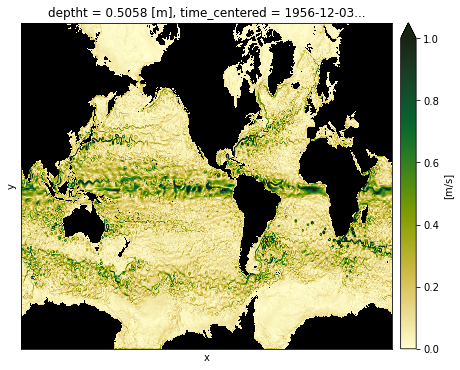

In [67]:
for ji, speed in enumerate(speeds):
    
    fig1, ax1 = plt.subplots(1,1, figsize=(8,6))
    
    # this will make NaNs black
    ax1.set_facecolor('black')
    
    _v = speed.sel(deptht=0, method='nearest')
    _vm = _v.where(_v != 0)
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[m/s]'}
    _vm.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.speed, 
                        vmin=0, vmax=1, 
                        cbar_kwargs=cbar_kwargs)
    
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_yticklabels([])

## Plot SST and ice

In [68]:
# Load data
ssts = []
ices = []

for ji, (ds_i, ds_t) in enumerate( zip(i_5d_all, t_5d_all) ):
    
    _sst = ds_t['sst'].isel(time=0).load()
    _ice = ds_i['ileadfra'].isel(time=0).load()
    
    ssts.append(_sst)
    ices.append(_ice)

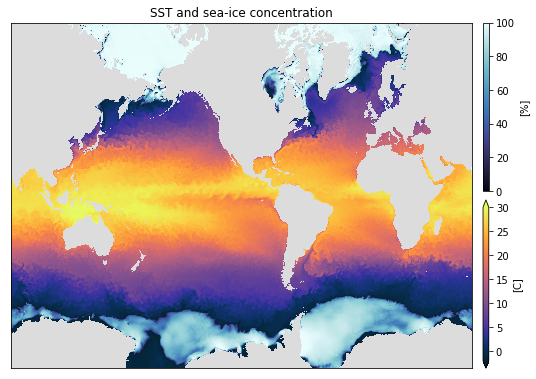

In [81]:
for ji, (sst,ice) in enumerate(zip(ssts,ices)):
    
    fig1 = plt.figure(figsize=(8,6))
    ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])
    cax1 = fig1.add_axes([0.92, 0.1, 0.01, 0.39])
    cax2 = fig1.add_axes([0.92, 0.51, 0.01, 0.39])
    
    # this will make NaNs black
    ax1.set_facecolor('Gainsboro')
    
    _sst = sst.where(sst != 0)
    _ice = ice.where(ice > 0.15) * 100
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[C]'}
    _sst.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.thermal, 
                         vmin=-2, vmax=30, 
                         cbar_kwargs=cbar_kwargs,
                         cbar_ax=cax1,
                         rasterized=True)
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[%]'}
    _ice.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.ice, 
                         vmin=0, vmax=100, 
                         cbar_kwargs=cbar_kwargs,
                         cbar_ax=cax2,
                         rasterized=True)
    
    ax1.set_xticks([])
    ax1.set_xlabel('')
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_ylabel('')
    ax1.set_title('SST and sea-ice concentration')
    
    fig1.savefig('figures/sst_ice.pdf', format='pdf', dpi=300)